In [16]:
from analysis.analysis import *
import matplotlib.pyplot as plt
from tqdm import tqdm

In [26]:
def heatmap(ax, F, bounds, xlabel=False, ylabel=False, cbar=False, cbar_label=False):
    xmin, xmax, vmin, vmax, nbins = bounds
    xmin, xmax = np.array([xmin, xmax]) - (xmax + xmin) / 2  # center along x
    ax.set_xlabel(r"$x$ ($\mu$m)") if xlabel else ...
    ax.set_ylabel(r"$v$ ($\mu$m/hr)") if ylabel else ...
    _kwargs = {
        "extent": [xmin, xmax, vmin, vmax],
        "origin": "lower",
        "cmap": "jet",
        "interpolation": "bilinear",
    }
    im = ax.imshow(F, **_kwargs)
    if cbar:
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_ticks([-1000, 0, 1000])
        cbar.formatter.set_powerlimits((0, 0))
        cbar.formatter.set_useMathText(True)
    cbar.set_label(r"$F$ ($\mu$m/hr$^2$)") if cbar_label else ...
    ax.set_aspect("auto")


def streamplot(
    ax, F, bounds, title="", n_skip=1, zero_line=False, heatmap=False, **kwargs
):
    xmin, xmax, vmin, vmax, nbins = bounds
    xmin, xmax = np.array([xmin, xmax]) - (xmax + xmin) / 2  # center along x
    ax.set_xlabel(r"$x$ ($\mu$m)")
    ax.set_ylabel(r"$v$ ($\mu$m/hr)")

    if heatmap:
        _kwargs = {
            "extent": [xmin, xmax, vmin, vmax],
            "origin": "lower",
            "cmap": "jet",
            "interpolation": "bilinear",
        }
        im = ax.imshow(F, **_kwargs)
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label(r"$F$ ($\mu$m/hr$^2$)")
        ax.set_aspect("auto")

    X, Y, init_pts = full_lattice(F, xmin, xmax, vmin, vmax, nbins)
    init_pts = init_pts[::n_skip]
    stream_kwargs = kwargs | {"start_points": init_pts}
    ax.streamplot(X, Y, Y, F, **stream_kwargs)
    ax.set_title(title)
    if zero_line:
        ax.hlines(0, *ax.get_xlim(), lw=1, color="black", zorder=-1)


def bistable_streamplot(
    ax,
    F,
    bounds,
    labels,
    end_pts,
    title="",
    n_skip=1,
    zero_line=False,
    heatmap=False,
    **kwargs
):
    xmin, xmax, vmin, vmax, nbins = bounds
    x_c = (xmax + xmin) / 2
    # x_c = 0
    xmin, xmax = np.array([xmin, xmax]) - x_c  # center along x
    ax.set_xlabel(r"$x$ ($\mu$m)")
    ax.set_ylabel(r"$v$ ($\mu$m/hr)")

    if heatmap:
        _kwargs = {
            "extent": [xmin, xmax, vmin, vmax],
            "origin": "lower",
            "cmap": "jet",
            "interpolation": "bilinear",
        }
        im = ax.imshow(F, **_kwargs)
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label(r"$F$ ($\mu$m/hr$^2$)")
        ax.set_aspect("auto")

    X, Y, init_pts = full_lattice(F, xmin, xmax, vmin, vmax, nbins)
    init_pts_sub = init_pts[::n_skip]
    labels_sub = labels[::n_skip]
    customs = ["tomato", "royalblue"]
    for k, color in enumerate(set(labels_sub)):
        if color == "gainsboro":
            continue

        inits_ = init_pts_sub[np.where(np.array(labels_sub) == color)[0]]
        color = customs[k-1]
        stream_kwargs = kwargs | {"color": color, "start_points": inits_}
        ax.streamplot(X, Y, Y, F, **stream_kwargs)
        ax.scatter(
            end_pts[:, 0] - x_c,
            end_pts[:, 1],
            s=50,
            marker="*",
            color="black",
            zorder=10,
        )
        xmin, xmax, vmin, vmax, nbins = bounds
        _, _, init_pts = full_lattice(F, xmin, xmax, vmin, vmax, nbins)
        img = lattice_to_image(init_pts, labels, bounds)
        septx = get_separatrices(
            img, levels=[0.5], origin="lower", extent=[xmin, xmax, vmin, vmax]
        )
        ax.plot(septx[:, 0] - x_c, septx[:, 1], lw=2, color="black")

    ax.set_title(title)
    if zero_line:
        ax.hlines(0, *ax.get_xlim(), lw=1, color="black", zorder=-1)


def dynamicsplot(ax, F, bounds, **kwargs):
    X, Y, init_pts = full_lattice(F, *bounds)

    # raw
    v, f = evaluate_F_v_x0(Y, F, bounds[-1])
    lim = np.fabs([v.min(), v.max()]).min()
    v_interp = np.linspace(-lim, lim, 30)
    f_interp = np.interp(v_interp, v, f)

    kwargs = {"lw": 2, "color": "black"} | kwargs
    ax.plot(v_interp, f_interp, "-o", **kwargs)
    ax.grid(which="major")
    ax.set_xlabel(r"$v$ ($\mu$m/hr)")
    ax.set_ylabel(r"$F(x\rightarrow 0)$ ($\mu$m/hr$^2$)")

In [18]:
def process_gid(gid):
    import pickle

    data = pickle.load(open(f"maps/map_{gid}.pkl", "rb"))
    if len(data["labels"]) > 0:
        return data["F"], data["bounds"], data["labels"], data["end_pts"]
    return data["F"], data["bounds"]

In [19]:
kwargs = {
    "density": 10,
    "linewidth": 0.5,
    "arrowsize": 1.0,
    "integration_direction": "forward",
    "broken_streamlines": True,
    "color": "cornflowerblue",
}
nskip = 7

---

### Fig 1

In [20]:
nrows, ncols = 1, 1
fig, axs = plt.subplots(nrows, ncols, figsize=(3.5 * ncols, 3.5 * nrows))
# axs.annotate("(iii)", xy=(0, 0), xytext=(-80, 170), fontsize=20)
heatmap(axs, *process_gid(10), xlabel=True, cbar=True, cbar_label=True)
streamplot(
    axs,
    *process_gid(10),
    n_skip=nskip,
    zero_line=True,
    **kwargs | {"color": "black"},
)
# plt.tight_layout()
fig.savefig(f"paper_plots/limit_cycle_defaults.pdf")
plt.close()

nrows, ncols = 1, 1
fig, axs = plt.subplots(nrows, ncols, figsize=(3.5 * ncols, 3.5 * nrows))
# axs.annotate("(iii)", xy=(0, 0), xytext=(-75, 130), fontsize=20)
heatmap(axs, *process_gid(26), xlabel=True, cbar=True, cbar_label=True)
streamplot(
    axs,
    *process_gid(26),
    n_skip=nskip,
    zero_line=True,
    **kwargs | {"color": "black"},
)
# plt.tight_layout()
fig.savefig(f"paper_plots/stationary_defaults.pdf")
plt.close()

nrows, ncols = 1, 1
fig, axs = plt.subplots(nrows, ncols, figsize=(3.5 * ncols, 3.5 * nrows))
# axs.annotate("(iii)", xy=(0, 0), xytext=(-90, 150), fontsize=20)
F, bounds, labels, end_pts = process_gid(2)
heatmap(axs, F, bounds, xlabel=True, cbar=True, cbar_label=True)
bistable_streamplot(
    axs,
    *process_gid(2),
    n_skip=nskip,
    zero_line=True,
    **kwargs | {"color": "black"},
)
# plt.tight_layout()
fig.savefig(f"paper_plots/bistable_defaults.pdf")
plt.close()

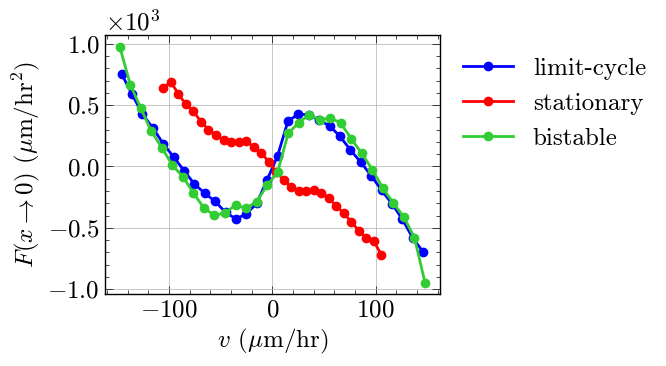

In [87]:
nrows, ncols = 1, 1
fig, axs = plt.subplots(nrows, ncols, figsize=(7 * ncols, 4 * nrows))
dynamicsplot(axs, *process_gid(10), color="blue", label="limit-cycle")
dynamicsplot(axs, *process_gid(26), color="red", label="stationary")
F, bounds, *temp = process_gid(2)
dynamicsplot(axs, F, bounds, color="limegreen", label="bistable")
axs.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig("paper_plots/nonlinear_plots.pdf")

### Fig. 2

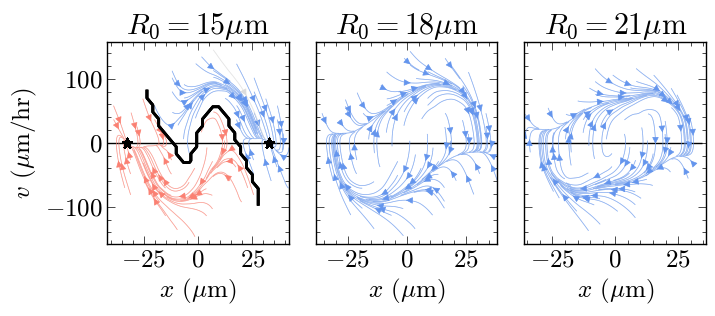

In [62]:
nrows, ncols = 1, 3
fig, axs = plt.subplots(nrows, ncols, figsize=(2.5 * ncols, 3.5 * nrows), sharey=True)

bistable_streamplot(
    axs[0],
    *process_gid(2),
    title=r"$R_0=15\mu\mathrm{m}$",
    n_skip=nskip,
    zero_line=True,
    **kwargs
)
streamplot(
    axs[1],
    *process_gid(10),
    title=r"$R_0=18\mu\mathrm{m}$",
    n_skip=nskip,
    zero_line=True,
    **kwargs
)
streamplot(
    axs[2],
    *process_gid(122),
    title=r"$R_0=21\mu\mathrm{m}$",
    n_skip=nskip,
    zero_line=True,
    **kwargs
)
[axs[k].set_ylabel("") for k in range(1, 3)]

plt.tight_layout()
fig.savefig("paper_plots/varying_cell_size_streams.pdf")

### Fig 3

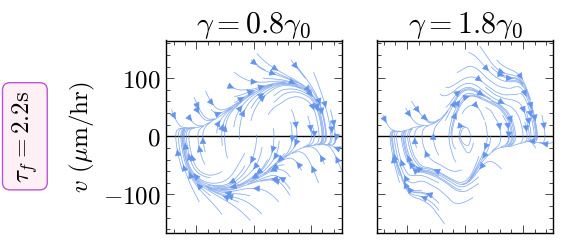

In [87]:
from matplotlib import colors


nrows, ncols = 1, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(2.5 * ncols, 2.5 * nrows), sharey=True)

streamplot(
    axs[0],
    *process_gid(10),
    title=r"$\gamma=0.8\gamma_0$",
    n_skip=nskip,
    zero_line=True,
    **kwargs
)
streamplot(
    axs[1],
    *process_gid(110),
    title=r"$\gamma=1.8\gamma_0$",
    n_skip=nskip,
    zero_line=True,
    **kwargs
)
axs[0].text(
    -100,
    0,
    r"$\tau_f=2.2$s",
    rotation=90,
    ha="center",
    va="center",
    bbox=dict(
        boxstyle="round",
        ec=colors.to_rgb("mediumorchid"),
        fc=colors.to_rgb("lavenderblush"),
    ),
)
axs[1].set_ylabel("")
axs[0].set_xlabel("")
axs[1].set_xlabel("")
axs[0].tick_params(labelbottom=False)
axs[1].tick_params(labelbottom=False)
plt.subplots_adjust(wspace=0.2)
fig.savefig("paper_plots/varying_cell_tension_streams_A.pdf")

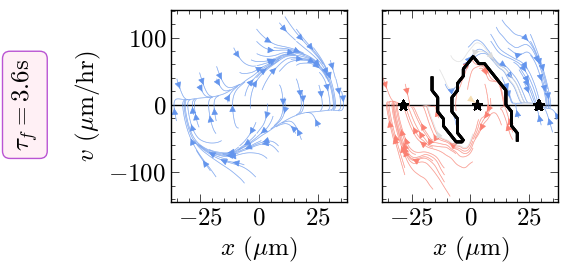

In [90]:
nrows, ncols = 1, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(2.5 * ncols, 2.5 * nrows), sharey=True)

streamplot(axs[0], *process_gid(145), n_skip=nskip, zero_line=True, **kwargs)
bistable_streamplot(axs[1], *process_gid(108), n_skip=nskip, zero_line=True, **kwargs)
axs[1].set_ylabel("")
axs[0].text(
    -100,
    0,
    r"$\tau_f=3.6$s",
    rotation=90,
    ha="center",
    va="center",
    bbox=dict(
        boxstyle="round",
        ec=colors.to_rgb("mediumorchid"),
        fc=colors.to_rgb("lavenderblush"),
    ),
)

plt.subplots_adjust(wspace=0.2)
fig.savefig("paper_plots/varying_cell_tension_streams_B.pdf")

### Fig 4

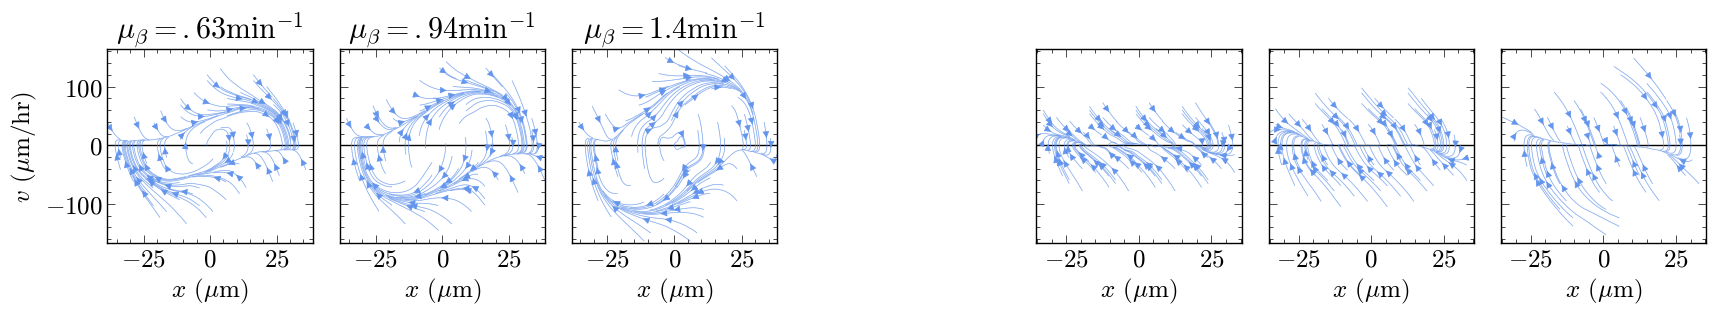

In [141]:
nrows, ncols = 1, 7
fig, axs = plt.subplots(nrows, ncols, figsize=(2.5 * ncols, 3.5 * nrows), sharey=True)

gids = [132, 10, 133, 10, 136, 26, 137]
titles = [
    r"$\mu_{\beta}=.63\mathrm{min}^{-1}$",
    r"$\mu_{\beta}=.94\mathrm{min}^{-1}$",
    r"$\mu_{\beta}=1.4\mathrm{min}^{-1}$",
    "",
    "",
    "",
    "",
]

# streams
[
    streamplot(
        ax, *process_gid(gid), title=title, n_skip=nskip, zero_line=True, **kwargs
    )
    for ax, gid, title in zip(axs, gids, titles)
]

# heatmaps
# [
#     heatmap(ax, *process_gid(gid), xlabel=True, ylabel=True)
#     for ax, gid, title in zip(axs, gids, titles)
# ]

[axs[k].set_ylabel("") for k in range(1, ncols)]
axs[3].remove()

plt.tight_layout()
fig.savefig("paper_plots/varying_mub_streams.pdf")

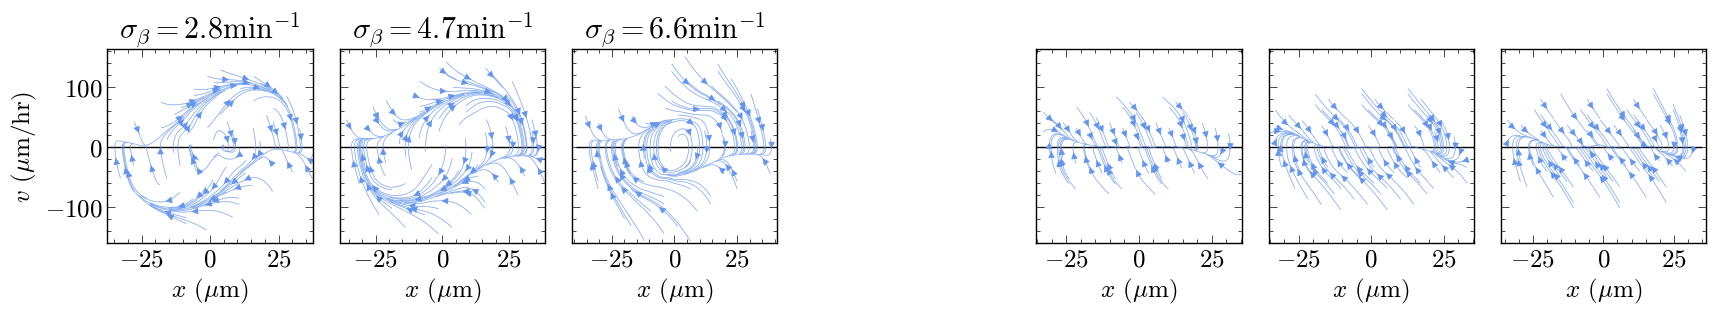

In [142]:
nrows, ncols = 1, 7
fig, axs = plt.subplots(nrows, ncols, figsize=(2.5 * ncols, 3.5 * nrows), sharey=True)

gids = [112, 10, 114, 10, 113, 26, 115]
titles = [
    r"$\sigma_{\beta}=2.8\mathrm{min}^{-1}$",
    r"$\sigma_{\beta}=4.7\mathrm{min}^{-1}$",
    r"$\sigma_{\beta}=6.6\mathrm{min}^{-1}$",
    "",
    "",
    "",
    "",
]

# streams
[
    streamplot(
        ax, *process_gid(gid), title=title, n_skip=nskip, zero_line=True, **kwargs
    )
    for ax, gid, title in zip(axs, gids, titles)
]

# heatmaps
# [
#     heatmap(ax, *process_gid(gid), xlabel=True, ylabel=True)
#     for ax, gid, title in zip(axs, gids, titles)
# ]

[axs[k].set_ylabel("") for k in range(1, ncols)]
axs[3].remove()

plt.tight_layout()
fig.savefig("paper_plots/varying_sigmab_streams.pdf")

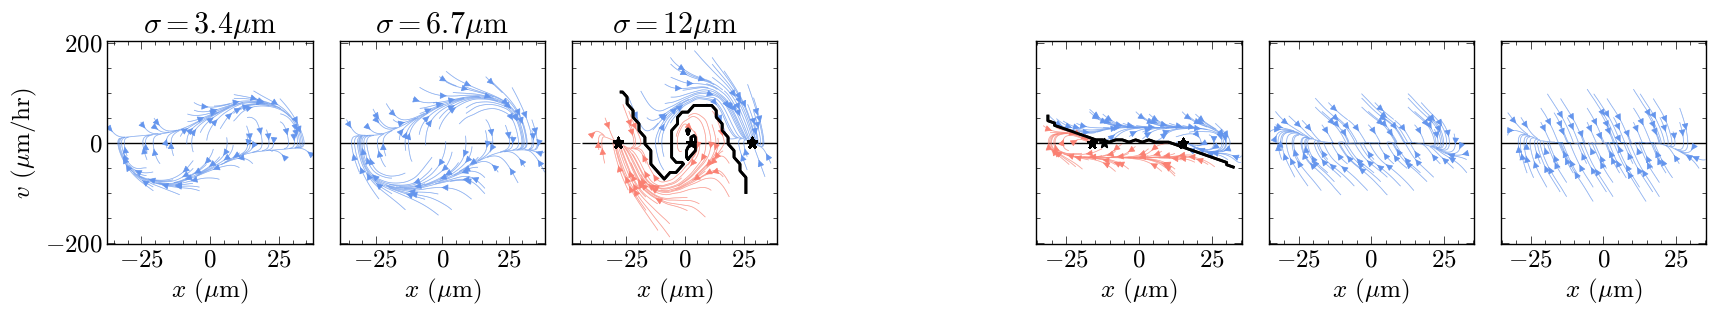

In [143]:
nrows, ncols = 1, 7
fig, axs = plt.subplots(nrows, ncols, figsize=(2.5 * ncols, 3.5 * nrows), sharey=True)

gids = [139, 10, 141, 10, 142, 26, 144]
titles = [
    r"$\sigma=3.4\mu \mathrm{m}$",
    r"$\sigma=6.7\mu \mathrm{m}$",
    r"$\sigma=12\mu \mathrm{m}$",
    "",
    "",
    "",
    "",
]

# streams
for ax, gid, title in zip(axs, gids, titles):
    # if gid != 141:
    #     ax.sharey(axs[0])

    if gid == 141 or gid == 142:
        bistable_streamplot(
            ax, *process_gid(gid), title=title, n_skip=nskip, zero_line=True, **kwargs
        )
        continue

    streamplot(
        ax, *process_gid(gid), title=title, n_skip=nskip, zero_line=True, **kwargs
    )

# heatmaps
# [
#     heatmap(ax, *process_gid(gid), xlabel=True, ylabel=True)
#     for ax, gid, title in zip(axs, gids, titles)
# ]

# [axs[k].tick_params(labelleft=False) for k in [1, 3, 4, 5, 6]]
[axs[k].set_ylabel("") for k in range(1, ncols)]
axs[3].remove()

plt.tight_layout()
fig.savefig("paper_plots/varying_sigma_streams.pdf")

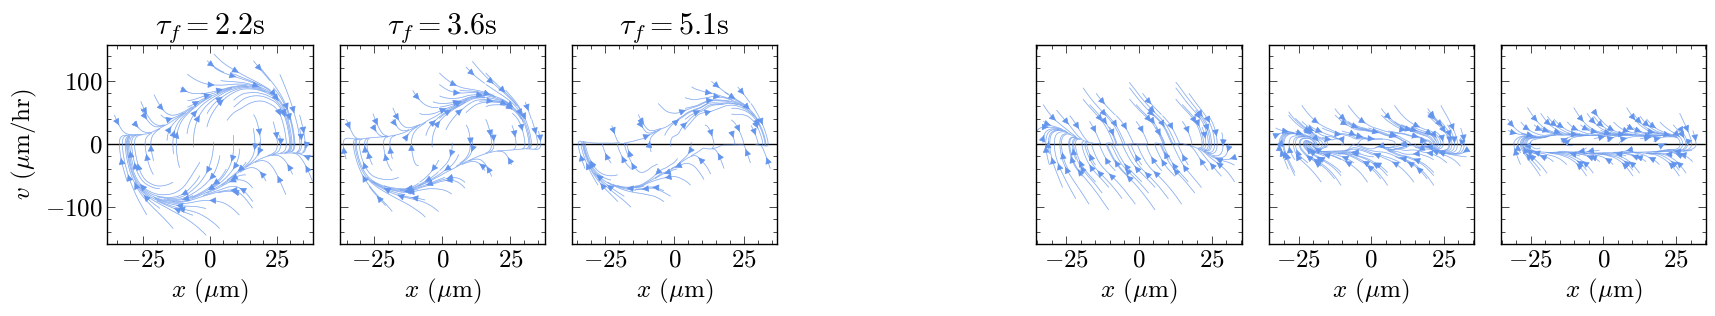

In [144]:
nrows, ncols = 1, 7
fig, axs = plt.subplots(nrows, ncols, figsize=(2.5 * ncols, 3.5 * nrows), sharey=True)

gids = [10, 145, 120, 10, 26, 146, 121]
titles = [
    r"$\tau_{f}=2.2\mathrm{s}$",
    r"$\tau_{f}=3.6\mathrm{s}$",
    r"$\tau_{f}=5.1\mathrm{s}$",
    "",
    "",
    "",
    "",
]

# streams
[
    streamplot(
        ax, *process_gid(gid), title=title, n_skip=nskip, zero_line=True, **kwargs
    )
    for ax, gid, title in zip(axs, gids, titles)
]

# heatmaps
# [
#     heatmap(ax, *process_gid(gid), xlabel=True, ylabel=True)
#     for ax, gid, _ in zip(axs, gids, titles)
# ]

[axs[k].set_ylabel("") for k in range(1, ncols)]
axs[3].remove()

plt.tight_layout()
fig.savefig("paper_plots/varying_tauf_streams.pdf")

### Fig. 5

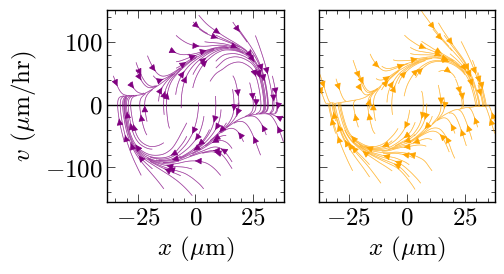

In [181]:
nrows, ncols = 1, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(2.5 * ncols, 2.5 * nrows), sharey=True)

streamplot(
    axs[0],
    *process_gid(10),
    n_skip=nskip,
    zero_line=True,
    **(kwargs | {"color": "purple"})
)
streamplot(
    axs[1],
    *process_gid(100),
    n_skip=nskip,
    zero_line=True,
    **(kwargs | {"color": "orange"})
)
axs[1].set_ylabel("")
plt.subplots_adjust(wspace=0.2)

fig.savefig("paper_plots/filopodia_knx.pdf")

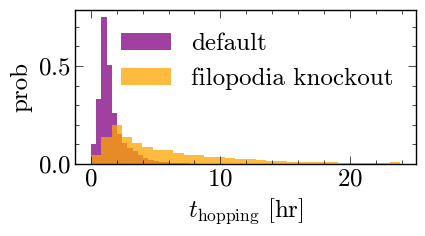

In [28]:
nrows, ncols = 1, 1
fig, axs = plt.subplots(nrows, ncols, figsize=(4.6 * ncols, 2.7 * nrows))
hist_kwargs = {"density": True, "bins": 30, "alpha": 0.75}
cs = ["purple", "orange"]
lbs = ["default", "filopodia knockout"]
for k, x in enumerate(
    [
        np.load(f"../_server/sim_data/defaults/hopping times/fulltake_gid10.npy"),
        np.load(f"../_server/sim_data/defaults/hopping times/fulltake_gid100.npy"),
    ]
):
    axs.hist(x, **(hist_kwargs | {"color": cs[k], "label": lbs[k]}))
axs.set_ylabel("prob")
axs.set_xlabel(r"$t_{\mathrm{hopping}}\ [\mathrm{hr}]$")
axs.legend()
plt.tight_layout()
plt.savefig("paper_plots/filopodia_knx_hopping_times.pdf")

### Fig. 6

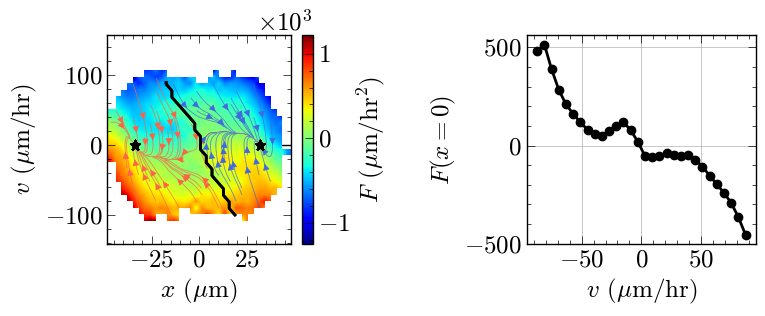

In [21]:
nrows, ncols = 1, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3.5 * nrows))

F, bounds, *temp = process_gid(4)
heatmap(axs[0], F, bounds, xlabel=True, cbar=True, cbar_label=True)
bistable_streamplot(
    axs[0],
    *process_gid(4),
    n_skip=nskip,
    zero_line=True,
    **(kwargs | {"color": "black"})
)
dynamicsplot(axs[1], F, bounds)

plt.tight_layout()
fig.savefig("paper_plots/tauX_knx.pdf")

### Fig. 7

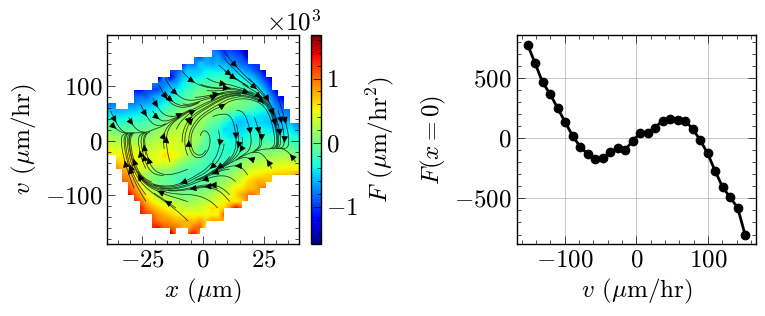

In [196]:
nrows, ncols = 1, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3.5 * nrows))

heatmap(axs[0], *process_gid(13), xlabel=True, cbar=True, cbar_label=True)
streamplot(
    axs[0],
    *process_gid(13),
    n_skip=nskip,
    zero_line=True,
    **(kwargs | {"color": "black"})
)
dynamicsplot(axs[1], *process_gid(13))

plt.tight_layout()
fig.savefig("paper_plots/tension_knx.pdf")